## Import packages and initial DataFrame

In [36]:
import pandas as pds
import numpy as np
import textdistance
import statsmodels.api as sm
import scipy
import math
import tqdm
import os
import seaborn as sns
from random import choices
from matplotlib import pyplot as plt

name_DF = 'DF_N=4401_2023-01-16.csv'
DF = pds.read_csv(os.path.join('..', 'datasets', name_DF), delimiter = ',')
DF = DF[~DF.duplicated()] # delete duplicates
DF = DF.dropna() # delete NaN values
DF['was_assigned_female'] = DF['was_assigned_female'].astype('int32') # turn was_born_female into int type (once Nan values have been removed)
DF = DF.drop(['name', 'family_name'], axis=1)

## Generate covariates, treatment and associations with outcome

In [37]:
# generate covariates
DF['X1'] = 2020 - DF['birth_year'] # age
DF['X2'] = np.random.normal(loc = 2.5, scale = 1, size = DF.shape[0])
DF['X3'] = np.random.normal(loc = 0, scale = 1, size = DF.shape[0])
DF['X4'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])
DF['X5'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])

# generate treatment
DF['treatment'] = np.random.binomial(n = 1, p = 1 / ( 1 + np.exp(0.1*DF.X1 -0.2*DF.X2 +0.3*DF.X3 -0.4*DF.X4 +0.5*DF.X5) )) # probability depending on covariates

# generate outcome
residual_errors = np.random.normal(size = DF.shape[0])
a = 5.5
b = 0.01
c = 0.08
d = 0.7

ate = a * 2.5
DF['Y'] = - 10 + a*DF['treatment']*DF['X2'] + b*np.exp(DF['X4']) + c*DF['X3']*DF['X1'] + d*DF['X5'] 

# generate new categorical variables for linkage
DF['id1'] = np.random.choice(np.arange(10), size = DF.shape[0]).astype(int)
DF['id2'] = np.random.choice(np.arange(15), size = DF.shape[0]).astype(int)
DF['id3'] = np.random.choice(np.arange(5), size = DF.shape[0]).astype(int)

## Linking variables i.e. identifiers are:
- sex
- country
- birth year
- id1
- id2
- id3

All categorical variables

In [38]:
identifiers = {'was_assigned_female':'strict','country':'strict','birth_year':'strict','id1':'strict','id2':'strict','id3':'strict'} # 'family_name':'jaro-winkler',
covariates = ['X1','X2','X3','X4','X5']

## Generate subdatasets A and B with common records

In [39]:
nbr_in_common = 60

common_records = DF.sample(n = nbr_in_common)

B = pds.concat([DF.sample(n = 150), common_records]).drop(['Y'], axis = 1)
B = B.reset_index(drop=True)

A = pds.concat([DF.sample(n = 250), common_records])[list(identifiers.keys())+['Y']]
A = A.reset_index(drop=True)

# delete some data --> typos
B.loc[np.random.choice(np.arange(B.shape[0]), size=5), 'id1'] = ''
A.loc[np.random.choice(np.arange(A.shape[0]), size=5), 'id3'] = ''
B.loc[np.random.choice(np.arange(B.shape[0]), size=5), 'id2'] = ''

In [40]:
common_records.head()

,name,family_name,country,birth_year,was_assigned_female,X1,X2,X3,X4,X5,treatment,Y,id1,id2,id3
2471,Николай,Курочкин,RU,1955,0,65,3.209247,-0.573719,-0.240296,1.351549,0,-12.029388,1,3,2
3738,Juan Carlos,Valeron Flaco,ES,1981,0,39,3.153542,-1.563226,2.551324,0.160369,0,-14.636768,0,11,4
334,Janika,Sillanpää,FI,1986,1,34,3.030111,0.124431,2.475773,1.710141,0,-8.345541,3,9,2
4310,Pat,Oneill,GB,2013,0,7,3.642899,-0.421160,1.083438,0.193035,0,-10.071177,3,5,0
1826,Salvatore,Panetta,IT,1948,0,72,1.862902,-1.571390,0.984189,-0.210552,0,-19.171840,0,3,3


In [41]:
A.head()

,was_assigned_female,country,birth_year,id1,id2,id3,Y
0,1,RU,1998,0,4,1,-10.202399
1,0,CZ,1961,1,0,4,-7.092782
2,1,CZ,1973,4,7,2,-8.693609
3,1,RU,1976,3,0,4,-5.614495
4,1,RU,1961,2,6,0,-8.137090


In [42]:
B.head()

,name,family_name,country,birth_year,was_assigned_female,X1,X2,X3,X4,X5,treatment,id1,id2,id3
0,Mara,Barschkett,DE,1959,1,61,2.448932,0.122693,1.903762,0.592528,0,5,0,2
1,Vincent,Allard,FR,2017,0,3,2.914626,-0.365194,1.166188,2.452837,0,3,3,4
2,Наталья,Мартынова,RU,1976,1,44,1.005040,-0.064691,-0.911468,2.432604,0,7,4,1
3,Татьяна,Потемкина,RU,1976,0,44,2.699331,-1.301206,1.177609,0.727039,0,2,10,0
4,Marie,Claire,FR,2017,0,3,0.964807,1.044702,-0.431818,1.006202,0,,9,3


## Write fucntions to compare linking variables among records
- Levenshtein similarity
- Jaro Winkler similarity
- Strict equality
- Large equality

In [43]:
def levenshtein_similarity(a,b):

    """ Check that levenshtein similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if 1 - textdistance.levenshtein(a, b)/max(len(a),len(b)) >= 0.95:
        return 1
    else:
        return 0

def jaro_winkler_similarity(a,b):

    """ Check that jaro-winkler similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if textdistance.jaro_winkler(a,b) >= 0.99:
        return 1
    else:
        return 0

def strict_equality(a,b):

    """ Check that a and b values are equal.
        
        a: any value,
        b: any value """

    return a==b

def large_equality(a,b):

    """ Check that years a and b expressed with four numbers are within the same decade.
        
        a: year,
        b: year """

    return str(a)[:-1]==str(b)[:-1]

## Write fucntions to compute the propensity score estimates based on covariates in a DataFrame

In [44]:
def logit(p):
    return np.log(p/(1-p))

def minmaxscaler(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    
def propensity_score(DF, covariates, scaler, convert_to_logit):
    
    """ Compute propensity score estimates: the probability (logistic regression) that an observation is treated or not conditioned on some covariates.
        These estimates are built conditionaly on covariates passed using a logit after transformation by scaler (when one is specified).
        Estimated probabilities can be converted into logit (convert_to_logit parameter).

        DF:                dataframe,
        covariates:        list of strings for covariates variable in DF,
        scaler:            sklearn.preprocessing function scaler for exemple,
        convert_to_logit:  boolean for converting probabilities to logit when building the propensity score estimates based on a logistic regression
    """
    exog = np.array(DF[covariates])
    if scaler != None:
        exog = scaler(exog)
    intercept = np.ones(DF.shape[0]).reshape(-1,1)
    exog = np.concatenate((exog, intercept), axis=1)
    model = sm.Logit(DF.treatment, exog).fit(disp=0)
    predictions = model.predict(exog)
    if convert_to_logit:
        return logit(predictions)
    else: 
        return predictions

In [45]:
B['propensity_score'] = propensity_score(B, covariates, None, False)

## Compute the cartesian product of all records in A and B
- add the source index (in A or B)
- add the linking score for each pair of records
- compute comparison vectors
- compute the probability of having same linking variables (at all and for matches)

In [46]:
AB = B.merge(A, how='cross', suffixes=("_B", "_A")) # preserve order of left keys: B file
AB["source_index_B"] = np.repeat(B.index, A.shape[0])
AB["source_index_A"] = np.tile(A.index, B.shape[0])

methods = {'jaro-winkler':jaro_winkler_similarity, 'levenshtein':levenshtein_similarity, 'strict':strict_equality, 'large':large_equality}

for linking_var in identifiers.keys():
    method = methods[identifiers[linking_var]]
    df = AB.filter(regex=linking_var)
    AB[linking_var+"_comparison"] = np.array([method(a, b) for a,b in zip(df.iloc[:,0], df.iloc[:,1])]).astype(int).reshape(-1,1)

comparison_vectors_only = AB.filter(regex="comparison")

AB

,name,family_name,country_B,birth_year_B,was_assigned_female_B,X1,X2,X3,X4,X5,...,id3_A,Y,source_index_B,source_index_A,was_assigned_female_comparison,country_comparison,birth_year_comparison,id1_comparison,id2_comparison,id3_comparison
0,Mara,Barschkett,DE,1959,1,61,2.448932,0.122693,1.903762,0.592528,...,1,-10.202399,0,0,1,0,0,0,0,0
1,Mara,Barschkett,DE,1959,1,61,2.448932,0.122693,1.903762,0.592528,...,4,-7.092782,0,1,0,0,0,0,1,0
2,Mara,Barschkett,DE,1959,1,61,2.448932,0.122693,1.903762,0.592528,...,2,-8.693609,0,2,1,0,0,0,0,1
3,Mara,Barschkett,DE,1959,1,61,2.448932,0.122693,1.903762,0.592528,...,4,-5.614495,0,3,1,0,0,0,1,0
4,Mara,Barschkett,DE,1959,1,61,2.448932,0.122693,1.903762,0.592528,...,0,-8.137090,0,4,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65095,Дмитрий,Коцарев,RU,1961,0,59,3.448689,1.241013,0.461850,0.473408,...,2,-8.752423,209,305,0,0,0,0,0,0
65096,Дмитрий,Коцарев,RU,1961,0,59,3.448689,1.241013,0.461850,0.473408,...,3,-12.543616,209,306,0,1,1,0,0,0
65097,Дмитрий,Коцарев,RU,1961,0,59,3.448689,1.241013,0.461850,0.473408,...,2,-9.656365,209,307,1,0,0,0,0,0
65098,Дмитрий,Коцарев,RU,1961,0,59,3.448689,1.241013,0.461850,0.473408,...,1,-7.878324,209,308,0,1,0,0,0,0


## Build the initial linkage
- find perfect comparisons between linking variables
- remove duplicates coming from A or from B
- on linked records, compute the propensity score
- build z0 the initial linkage estimates
- compute the true linkage (based on the common records subdataset built at the start)

For each record in $B$ we find the best match in $A$

Produce the linkage variable $$z_j = \left\{
    \begin{array}{ll}
        i & \text{if } \{i,j\} \text{ are matched} \\
        j + n_A & \text{otherwise.}
    \end{array}
\right.$$

In [49]:
where_good_comparisons = AB[comparison_vectors_only[['was_assigned_female_comparison', 'country_comparison', 'birth_year_comparison', 'id1_comparison', 'id2_comparison', 'id3_comparison']].all(axis=1)] # 'family_name_comparison', 

# remove duplicata: 
where_good_comparisons = where_good_comparisons[ (~where_good_comparisons.source_index_A.duplicated(keep=False)) & (~where_good_comparisons.source_index_B.duplicated(keep=False)) ]

idx_A = where_good_comparisons.source_index_A
idx_B = where_good_comparisons.source_index_B

z_init = -np.ones(B.shape[0])
z_init[idx_B] = idx_A

true_linkage_z = -np.ones(B.shape[0])
true_linkage_z[B.iloc[-nbr_in_common:,:].index] = A.iloc[-nbr_in_common:,:].index

Because the linkage estimate is built by removing duplicates from A and B to enforce 1-2-1 matching we miss some matches and make some errors. We evaluate the proportion of good estimations below:

In [50]:
(z_init == true_linkage_z).sum() / len(true_linkage_z)

0.9047619047619048

In [51]:
intercept = np.ones(AB.shape[0])
records_treatment =  np.array(AB.treatment)
records_propensity_score = np.array(AB.propensity_score)
interaction_term = records_treatment * records_propensity_score
XX = np.concatenate([intercept.reshape(-1,1), records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)

## Remarks

- Launch the algorithm with a different initial linkage variable $z$
    - with a stupid $z$ (almost all records non linked: set to -1, and the first 10 records linked with the other first 10 records)
    - with a smart $z$ (80% of the values correspond to the true linkage variable, values might be link or no link)

    $\to$ the algorithm returns similar results


- Check the 5 best matches (best match meaning high probability to be chosen) comparison vectors

    $\to$ comparison vectors for possible matches are consistent (intervene in $w_1$, seems that given similar comparison vectors for probable matches, a high weight is attributed to the one that differs?)


- Check the 5 best matches propensity score

    $\to$ for one record in $B$ we have a propensity score, therefore possibles matches for the record in $B$ have the same propensity score
    $\to$ distribution of linked outcomes is based on:
    - $\varepsilon = Y - X \beta$ 
    - $Y$ from the cartesian product (outcomes from $A$ that are duplicate because of the need to match shape with $X$)
    - $X$ from the cartesian product (propensity score and treatment from $B$ that are duplicate because of the need to match shape with $Y$)
    - $\beta$ computed on previously linked data
        
    $\to$ distribution of non linked outcomes is based on:
    - (normal distr.) parameters computed on previously non linked data (including all possible pairs of records minus the ones decided to be matches)
    - $Y$ from the cartesian product (outcomes from $A$ that are duplicate because of the need to match both distributions for linked and non linked outcomes)


- Change priors ($\alpha_{\pi}, \beta_{\pi}$)

    $\mathbb P (unmatch) = (n_A - \#match) \times (n_B - \#match - 1 + \beta_{\pi}) / (\#match + \alpha_{\pi})$
    $\to$ to enforce the algorithm not to match everything we can:
    - increase $\beta_{\pi}$
    - decrease $\alpha_{\pi}$
    Increasing $\beta_{\pi}$ for example changes the willingness of the algorithm to make links at each MCMC iteration but does not change the linkage in the end (which is computed on the matches having high probabilities over all iterations)


- Change initial coefficient for the outcome regression

    $\to$ I don t know the true coefficient because in reality the outcome model / response model is not build on the porpensity score

- Outcome regression idea: try the same regression for link and non link data but fit $\beta$ depending on link or non link status

    $\to$ on the cartesian product of $A$ and $B$ considering non linked data we can fir $\beta$ to apply the same response model than for linked data, however a few data are matched then (not enough to prevent perfect separation when computing propensity scores on links)

In [52]:
cartesian_product_AB = AB.copy(())

new_z = -np.ones(B.shape[0])
new_z[::2] = np.arange(len(new_z[::2])) # 1 value over 2 is assigned to a record in A

comparison_vectors = comparison_vectors_only.copy()
covariates = covariates.copy()
n_A = A.shape[0]
n_B = B.shape[0]
X = XX.copy()

idx_match_A = new_z[new_z>=0]
idx_match_B = np.nonzero(new_z>=0)[0]
links = pds.MultiIndex.from_tuples(zip(idx_match_A,idx_match_B))
pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])
dict_empirical_count_linkage = {pair:0 for pair in pairs}

nbr_iter = 800

a_sigma, b_sigma, a_sigma2, b_sigma2, a, b, alpha_pi, beta_pi = 1, 1, 1, 1, 1, 1, 1, 1
Betas = scipy.stats.multivariate_normal.rvs(np.array([0,0,0]), np.eye(3))
Betas_non = scipy.stats.multivariate_normal.rvs(np.array([0,0,0]), np.eye(3))
mu2 = scipy.stats.norm.rvs(0, 1)

for _ in tqdm.tqdm(range(nbr_iter)):

    ### --  UPDATE THETA --> match, unmatch
    comparison_vectors_for_non_matches = comparison_vectors[~pairs.isin(links)]
    unmatch = scipy.stats.beta.rvs(comparison_vectors_for_non_matches.sum(axis=0) + a, (1-comparison_vectors_for_non_matches).sum(axis=0) + b)
    comparison_vectors_for_matches = comparison_vectors[pairs.isin(links)]
    match = scipy.stats.beta.rvs(comparison_vectors_for_matches.sum(axis=0) + a, (1-comparison_vectors_for_matches).sum(axis=0) + b)

    ### --  UPDATE COEF OUTCOME MODEL (MATCHES AND NON MATCHES) --> Betas --> mu2, sigma2_square --> outcome model distribution
    data_for_matches = cartesian_product_AB[pairs.isin(links)]
    outcome_for_matches =  np.array(data_for_matches.Y)
    treatment_for_matches =  np.array(data_for_matches.treatment)
    linked_records_propensity_score = propensity_score(data_for_matches, covariates, None, False)
    interaction_term = treatment_for_matches * linked_records_propensity_score
    K = np.concatenate([np.ones(len(outcome_for_matches)).reshape(-1,1), linked_records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)
    n_AB = sum(new_z>=0)
    sigma_square = scipy.stats.invgauss.rvs(a_sigma + n_AB/2, np.linalg.norm(outcome_for_matches - K @ np.array(Betas))**2 / 2 + b_sigma)
    Sigma_beta = np.linalg.inv( (K.T @ K)/sigma_square + np.eye(K.shape[1]) )
    mu_beta = Sigma_beta @ (K.T @ outcome_for_matches)/sigma_square
    Betas = scipy.stats.multivariate_normal.rvs(mu_beta, Sigma_beta)
    data_for_non_matches = A[~A.index.isin(idx_match_A)]
    outcome_for_non_matches =  np.array(data_for_non_matches.Y)
    sigma2_square = scipy.stats.invgauss.rvs(a_sigma2 + (n_A - n_AB)/2, b_sigma2 + sum((outcome_for_non_matches - mu2)**2)/2)
    sigma_mu2_square = 1/((n_A - n_AB)/sigma2_square + 1)
    m_mu2 = sigma_mu2_square * (outcome_for_non_matches).sum() / sigma2_square
    mu2 = scipy.stats.norm.rvs(m_mu2, np.sqrt(sigma_mu2_square))
    residuals = cartesian_product_AB.Y - X @ Betas.T
    estimated_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))
    distr_linked_outcomes = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
    distr_non_linked_outcomes = scipy.stats.norm.pdf(cartesian_product_AB.Y, mu2, np.sqrt(sigma2_square))

    ### --  UPDATE PROBABILITIES
    w1 = ( np.multiply( comparison_vectors, np.log(match/unmatch) ) + np.multiply( 1-comparison_vectors, np.log((1-match)/(1-unmatch)) ) ).sum(axis=1)
    w2 = np.log(distr_linked_outcomes / distr_non_linked_outcomes)
    probabilities = np.array(np.exp(w1+w2))
    probabilities = probabilities.reshape(n_B, n_A)

    for j in range(n_B):

        n_AB_ = (np.delete(new_z, j)>=0).sum()
        proba_for_unmatch = (n_A - n_AB_) * (n_B - n_AB_ - 1 + beta_pi) / (n_AB_ + alpha_pi)
        not_possible_values = list( set(np.delete(new_z, j).astype(int)) - set([-1]) )
        proba = probabilities[j,:].copy()
        proba[not_possible_values]  = 0
        proba = np.append(proba, proba_for_unmatch)
        idx_max_proba = np.argpartition(proba, -5)[-5:]
        possible_values = np.arange(n_A)
        possible_values = np.append(possible_values, -1)

        val = choices(possible_values[idx_max_proba], weights = proba[idx_max_proba])[0]
        new_z[j] = val

    ### _ UPDATE INDICES FOR MATCHES
    idx_match_A = new_z[new_z>=0]
    idx_match_B = np.nonzero(new_z>=0)[0]
    links = pds.MultiIndex.from_tuples(zip(idx_match_A,idx_match_B))
    pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])

    for link in links: # check burn-in
        dict_empirical_count_linkage[link] += 1

v = np.array(list(dict_empirical_count_linkage.values())) / nbr_iter
k = np.array(list(dict_empirical_count_linkage.keys()))

100%|██████████| 800/800 [01:08<00:00, 11.76it/s]


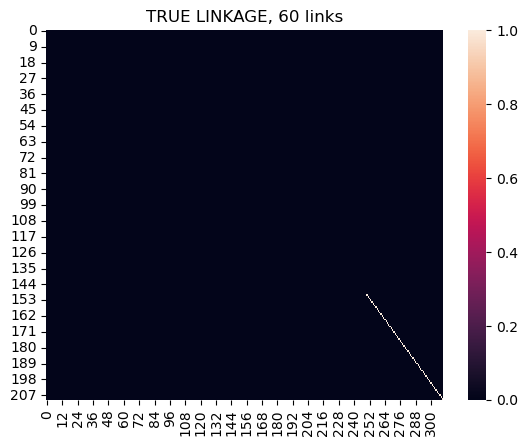

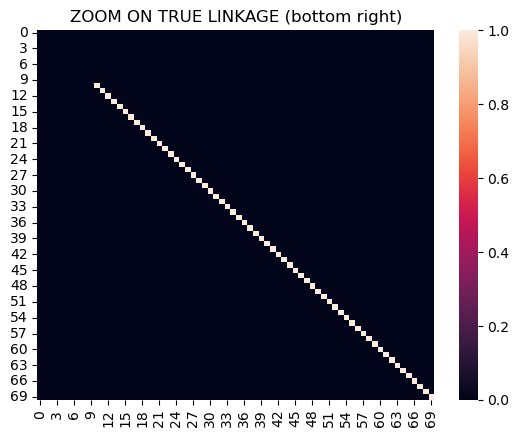

In [53]:
z_linkage_vector = true_linkage_z.copy()

idx_in_A_links = z_linkage_vector[z_linkage_vector>=0]
idx_in_B_links = np.nonzero(z_linkage_vector>=0)[0]
linkage_matrix = np.zeros((B.shape[0], A.shape[0]))

for link in range(len(idx_in_A_links)):
    linkage_matrix[int(idx_in_B_links[link]), int(idx_in_A_links[link])] = 1

sns.heatmap(linkage_matrix)
plt.title(f"TRUE LINKAGE, {(linkage_matrix==1).sum()} links")
plt.savefig(f"true_linkage_{(linkage_matrix==1).sum()}links.pdf", format="pdf", bbox_inches="tight")
plt.show()

sns.heatmap(linkage_matrix[140:, 240:])
plt.title(f"ZOOM ON TRUE LINKAGE (bottom right)")
plt.savefig(f"zoom_true_linkage_(bottom-right).pdf", format="pdf", bbox_inches="tight")
plt.show()

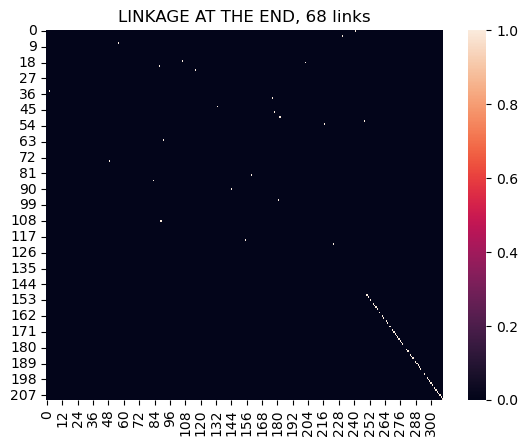

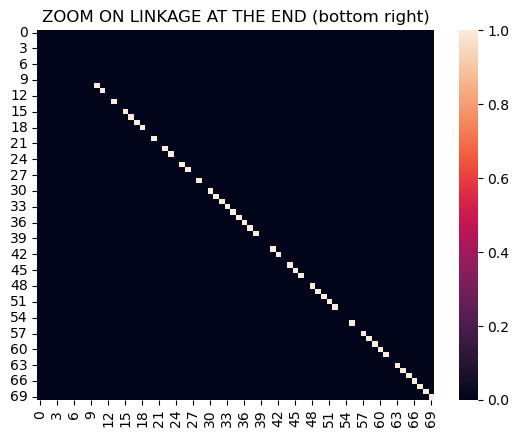

In [56]:
best = k[v>=0.8]
idx_A = best[:,0]
idx_B = best[:,1]

linkage_matrix = np.zeros((B.shape[0], A.shape[0]))

for link in range(len(idx_A)):
    A_idx = idx_A[link]
    B_idx = idx_B[link]
    linkage_matrix[B_idx, A_idx] = 1

sns.heatmap(linkage_matrix)
plt.title(f"LINKAGE AT THE END, {(linkage_matrix==1).sum()} links")
plt.savefig(f"linkage_at_end_{(linkage_matrix==1).sum()}links.pdf", format="pdf", bbox_inches="tight")
plt.show()

sns.heatmap(linkage_matrix[140:, 240:])
plt.title(f"ZOOM ON LINKAGE AT THE END (bottom right)")
plt.savefig(f"linkage_at_end_(bottom-right).pdf", format="pdf", bbox_inches="tight")
plt.show()